<a href="https://colab.research.google.com/github/martintesta/Stock_predictions_w_LSTM/blob/main/LSTM_Predicting_Stock_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#importamos la librerias que vamos a usar
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
import io
import math


In [27]:
'''
Carga, tansformación y checkeo de los datos
'''

from google.colab import files
uploaded = files.upload()

#leemos el csv donde tenemos la información
df = pd.read_csv(io.BytesIO(uploaded['AMC.csv']))

#print de los primeros 10 aprox para ver como luce el df con el que vamos a trabajar
df.head()

Saving AMC.csv to AMC (1).csv


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,18-12-2013,18.900000,19.180000,5457200,19.790001,18.900000,13.593413
1,19-12-2013,18.809999,18.900000,1605400,19.490000,19.490000,14.017756
2,20-12-2013,19.400000,19.650000,737100,19.770000,19.680000,14.154408
3,23-12-2013,19.500000,19.790001,698100,19.990000,19.740000,14.197561
4,24-12-2013,19.500000,19.740000,213700,19.820000,19.530001,14.046530


In [28]:
'''
Estandarización/normalización de la data
'''
#Para normalizar la data - se normaliza para que todos los datos puedan representar el valor que tienen
#No todas las veces se debe de normalizar los datos. La regla de dedo gordo es de normalizar cuando son rangos variables no definidos
#Ejemplo son precios que pueden ir de 0 a muy grande, en vez de ser una escala definida de 1 a 5.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
print(len(df))

2054


In [32]:


'''
Preapración y masajeo de los datos
'''



#creamos el diccionario donde vamos a guardar la información. 
#Es importante mantener el órden cronológico de los datos
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#Cramos el index y luego hacemos drop de la feature (columna) que no vamos a usar
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#dividimos el set de datos en Train y Test
dataset = new_data.values

#en la anterior celda vimos el tamaño del df entonces lo dividimos en 80/20
train = dataset[0:1643,:]
test = dataset[1643:,:]

#convertimos el dataset en x (x_train) e y (y_train)
#además creamos la variable scaler para futuro uso
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

'''
Ahora vamos a crear la red LSTM
El modelo LSTM ya viene pre cargado en una función
'''
#Elegimos el modelo Sequencial() de Keras por qué 
#es apropiado para cuando tenemos un "secuencia" o "pila" de capas simples
#donde cada capa tiene exactamente un tensor de entrada y un tensor de salida.
modelo = Sequential()

#Vamos a descomoner un poco las capas o layers
#uso .add para decirle al secuencial que algoritmo voy a usar en este caso el LSTM
#Cuando agrego LSTM tengo que pensar en que significa cada variable que agrego dentro
#Units = Integral positivo referencia a dimensionalidad de la capa de salida
#Primera capa
modelo.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
#Segunda capa
modelo.add(LSTM(units=50))
#Capa de Salida
modelo.add(Dense(1))

modelo.compile(loss='mean_squared_error', optimizer='adam')
modelo.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#prediciendo 246 valores, utilizado los últimos 60 de train = dataset[0:1643,:]
inputs = new_data[len(new_data) - len(test) - 60:].values
#Importantisimo paso de matriz de len(train) & len(test) x 2 filas a vector 1x1
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
#inputs.shape[0] es un uso general indicando que el tensor comienza desde la posición 0
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = modelo.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

1583/1583 - 30s - loss: 7.3688e-04 - 30s/epoch - 19ms/step


In [ ]:
#Error mínimo cuadrado para saber que tan alejados estan los puntos de error de la recta que representa a la  media de todos los puntos
#RMSE solo sirve para comparar errores de predicción de diferentes modelos o configuraciones de modelos para una (1) variable en particular y no entre variables, ya que depende de la escala.
#Cuando más cerca de cero quiere decir que tus puntos más se acercan a la recta que representa la media de todos los errores de lo valores predecidos
rms=np.sqrt(np.mean(np.power((test-closing_price),2)))
rms

3.1581864867771614

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


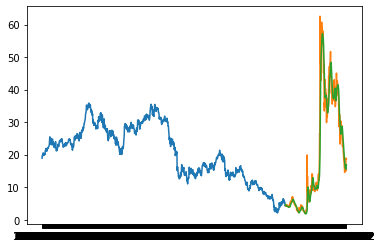

In [30]:
#Represnetamos gráficamente
train = new_data[:1643]
test = new_data[1643:]
test['Predictions'] = closing_price
plt.plot(train['Close']) 
plt.plot(test[['Close','Predictions']]) 
#naranja el real precio de la acción
#lo azul la data usada o sea toda lada data
#Lo naranja fue la data de entrenamiento que es data real
#Lo verde es la predicción

In [16]:
train_predict=model.predict(x_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
math.sqrt(mean_squared_error(y_train,train_predict))

21.529161064953467